In [4]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import DataLoader, Dataset
from PIL import Image

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

from PIL import UnidentifiedImageError

class LegoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, self.image_list[index])
        try:
            image = Image.open(img_name).convert("RGB")
        except (UnidentifiedImageError, OSError):
            dummy_image = Image.new("RGB", (64, 64))
            if self.transform is not None:
                dummy_image = self.transform(dummy_image)
            return dummy_image

        if self.transform is not None:
            image = self.transform(image)

        return image


data_path = "minifig_images" # TODO: Resolve
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = LegoDataset(root_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)


class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


nz = 100  # Latent vector (noise)
ngf = 128  #  Generator filters
ndf = 128  # Discriminator filters
nc = 3    # Image channels - RGB

device = torch.device("cpu")
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))


num_epochs = 1
output_dir = "minifig_output"
os.makedirs(output_dir, exist_ok=True)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_images = data.to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size, 1, 1, 1), 1.0, device=device)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)

        # Discriminator: maximize ln( D(x) ) + ln( 1 - D(G(z)) )
        netD.zero_grad()
        output_real = netD(real_images)
        errD_real = criterion(output_real, label)
        errD_real.backward()
        D_x = output_real.mean().item()

        fake_images = netG(noise)
        label.fill_(0.0)
        output_fake = netD(fake_images.detach())
        errD_fake = criterion(output_fake, label)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Generator: maximize ln( D(G(z)) )
        netG.zero_grad()
        label.fill_(1.0)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Printing
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}] "
                f"Loss_D: {errD.item():.4f} "
                f"Loss_G: {errG.item():.4f} "
                f"D(x): {D_x:.4f} "
                f"D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"
            )

    # Save generated images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(
            fake, f"{output_dir}/fake_samples_epoch_{epoch + 1}.png",
            normalize=True,
        )

# Save the final generator model
torch.save(netG.state_dict(), "dcgan_generator.pth")

Random Seed:  3692


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'minifig_images'

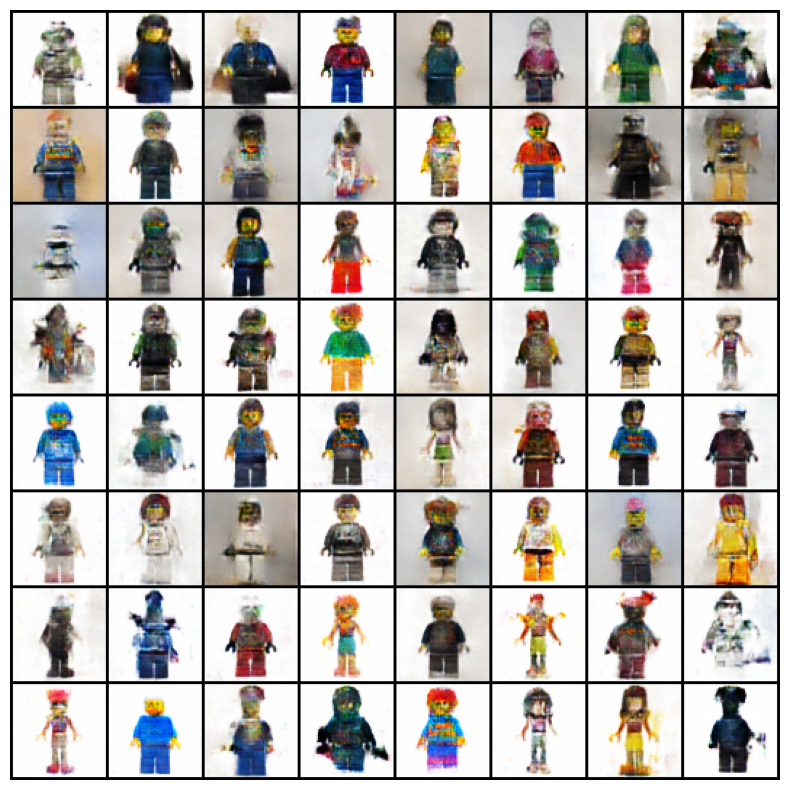

In [29]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

transform_vis = transforms.Compose([
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
    transforms.ToPILImage() 
])

# Same as before - Generator
nz = 100 
ngf = 64 
nc = 3

device = torch.device("cpu")
netG = Generator(nz, ngf, nc).to(device)
netG.load_state_dict(torch.load("dcgan_generator.pth", map_location=device))
netG.eval() 

num_images_to_generate = 64
fixed_noise = torch.randn(num_images_to_generate, nz, 1, 1, device=device)

with torch.no_grad():
    generated_images = netG(fixed_noise).detach().cpu()

grid = vutils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(transform_vis(grid))
plt.axis("off")
plt.show()
